In [1]:
import sys
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray
import rasterio
import geemap
import matplotlib.pyplot as plt
os.chdir("C:/Users/cshat/eo/EFFIS-ERA5-EUROPE")
sys.path.insert(0, os.getcwd())

import ee
import scripts.fwi_functions as fwi_functions

In [85]:
import cdsapi

dataset = "insitu-gridded-observations-europe"
request = {
    "product_type": "ensemble_mean",
    "variable": [
        "mean_temperature",
        "precipitation_amount",
        "relative_humidity",
        "wind_speed"
    ],
    "grid_resolution": "0_1deg",
    "period": "2011_2024",
    "version": ["30_0e"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-03-02 21:26:24,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-02 21:26:24,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-02 21:26:24,730 INFO Request ID is d276d419-0a69-4407-9ddd-5942fe08e6fe
2025-03-02 21:26:24,831 INFO status has been updated to accepted
2025-03-02 21:26:29,831 INFO status has been updated to running
2025-03-02 21:26:33,281 INFO status has been updated to accepted
2025-03-02 21:26:38,414 INFO status has been updated to successful


161d16b471558818364712c8730daf6e.zip:   0%|          | 0.00/3.30G [00:00<?, ?B/s]

'161d16b471558818364712c8730daf6e.zip'

In [ ]:
dataset = "insitu-gridded-observations-europe"
request = {
    "product_type": "ensemble_mean",
    "variable": [
        "mean_temperature",
        "precipitation_amount",
        "relative_humidity",
        "wind_speed"
    ],
    "grid_resolution": "0_1deg",
    "period": "1995_2010",
    "version": ["30_0e"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-03-02 21:31:50,837 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-02 21:31:50,837 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-02 21:31:51,038 INFO Request ID is fe44ed56-0eaa-4ba7-8464-fff136f7721e
2025-03-02 21:31:51,116 INFO status has been updated to accepted
2025-03-02 21:32:04,671 INFO status has been updated to running
2025-03-02 21:50:11,479 INFO status has been updated to successful


1eb27c3b9afd457d662d055d2b62d823.zip:   0%|          | 0.00/4.11G [00:00<?, ?B/s]

In [ ]:
ee.Initialize(project='ee-kiwa') 

In [3]:
# load Europe shapefile
europe = gpd.read_file('data/europe-boundary/Europe.shp')
nonEurope_country = ['Turkey', 'Kazakhstan', 'Armenia', 'Azerbaijan', 'Georgia','Russia','Svalbard (Norway)','Jan Mayen (Norway)'] #remove non-European countries (EEA38)
europe_filtered = europe[~europe['NAME'].isin(nonEurope_country)]
europe_filtered = europe_filtered[['NAME','geometry']]
europe_outline = europe_filtered.dissolve() #Get outline of Europe for clipping
europe_outline.loc[:, 'NAME'] = 'Europe'
# Extract the dissolved geometry (a single shapely geometry)
shapely_geom = europe_outline.geometry.iloc[0]

# Convert the shapely geometry to a GeoJSON-like dict using __geo_interface__
geojson_geom = shapely_geom.__geo_interface__



In [81]:
era5_path_0 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/d3cb434725d92354d919deddabb98091/data_0.nc"
era5_0 = rioxarray.open_rasterio(era5_path_0)
era5_0

<xarray.Dataset> Size: 2GB
Dimensions:      (x: 601, y: 351, valid_time: 300)
Coordinates:
  * x            (x) float64 5kB -10.0 -9.9 -9.8 -9.7 ... 49.7 49.8 49.9 50.0
  * y            (y) float64 3kB 70.0 69.9 69.8 69.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-12-01 0...
    spatial_ref  int32 4B 0
Data variables:
    lai_lv       (valid_time, y, x) float32 253MB ...
    lai_hv       (valid_time, y, x) float32 253MB ...
    u10          (valid_time, y, x) float32 253MB ...
    v10          (valid_time, y, x) float32 253MB ...
    t2m          (valid_time, y, x) float32 253MB ...
    d2m          (valid_time, y, x) float32 253MB ...
    evatc        (valid_time, y, x) float32 253MB ...
    evavt        (valid_time, y, x) float32 253MB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

In [4]:
era5_path_0 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_0.nc"
era5_path_1 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_1.nc"
era5_path_2 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_2.nc"
# era5_path = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/  data_1.nc"
era5_0 = rioxarray.open_rasterio(era5_path_0)
era5_0 = era5_0[['t2m', 'd2m', 'u10', 'v10']]
era5_1 = rioxarray.open_rasterio(era5_path_1)
era5_1 = era5_1[['tp', 'pev']]


In [5]:
combined_dataset = xr.merge([era5_0, era5_1])


In [6]:
# Convert temperatures from Kelvin to Celsius.
t2m_C = combined_dataset['t2m'] - 273.15
d2m_C = combined_dataset['d2m'] - 273.15

# Compute saturation vapor pressure (e_s) and actual vapor pressure (e_a) using the Tetens formula.
# Formula: e = 6.112 * exp((17.67 * T) / (T + 243.5))  where T is in Celsius, result in hPa.
e_s = 6.112 * np.exp((17.67 * t2m_C) / (t2m_C + 243.5))
e_a = 6.112 * np.exp((17.67 * d2m_C) / (d2m_C + 243.5))

# Calculate relative humidity (RH) in percentage.
RH = 100 * (e_a / e_s)

# Add the RH as a new data variable to the combined dataset.
combined_dataset = combined_dataset.assign(RH=RH)

In [7]:
combined_dataset = combined_dataset.assign(t2m_C=t2m_C)
combined_dataset = combined_dataset.assign(d2m_C=d2m_C)

In [35]:
# Calculate wind speed using the Pythagorean theorem.
# windspeed = sqrt(u10^2 + v10^2)
windspeed_m_s = np.sqrt(combined_dataset['u10']**2 + combined_dataset['v10']**2)
windspeed_km_h = windspeed_m_s * 3.6
# Add windspeed as a new data variable to the combined dataset.
combined_dataset = combined_dataset.assign(windspeed=windspeed_km_h)

In [69]:
# Convert precipitation from meters to millimeters
combined_dataset['tp_mm'] = combined_dataset['tp'] * 1000

In [70]:
### FWI Calculation #1
"""
Compute the Canadian Forest Fire Weather Index (FWI) from daily meteorological inputs.
The formulas are based on Van Wagner (1987) and subsequent refinements.
Note: This implementation assumes that:
    - Temperature is provided in °C.
    - Relative Humidity is in %.
    - Wind speed is provided in km/h.
    - Precipitation is in mm.
The system is recursive, so previous day values for FFMC, DMC, and DC must be supplied.
"""

import numpy as np 
import xarray as xr 

def calc_ffmc(T, RH, wind, rain, ffmc_yesterday):
    """
    Calculate the Fine Fuel Moisture Code (FFMC).
    
    Parameters:
      T : xarray.DataArray or np.array
          Daily air temperature in °C.
      RH : xarray.DataArray or np.array
          Daily relative humidity in %.
      wind : xarray.DataArray or np.array
          Daily wind speed in km/h.
      rain : xarray.DataArray or np.array
          Daily precipitation in mm.
      ffmc_yesterday : xarray.DataArray or np.array
          Yesterday's FFMC (unitless, typically initialized around 85).
          
    Returns:
      ffmc : xarray.DataArray or np.array
          Today's FFMC.
    """
    # Convert previous FFMC to moisture content (m_o)
    m_o = 147.2 * (101.0 - ffmc_yesterday) / (59.5 + ffmc_yesterday)
    
    # Rainfall effect: only effective if rain > 0.5 mm
    # Effective rainfall (rf)
    rf = xr.where(rain > 0.5, rain - 0.5, 0.0)
    
    # Update moisture content after rain (m_r)
    # The following equations adjust m_o by the rain effect.
    # There are two regimes depending on whether m_o is below or above 150.
    m_r = xr.where(
        rf > 0,
        xr.where(m_o <= 150.0,
                 m_o + 42.5 * rf * np.exp(-100.0 / (251.0 - m_o)) * (1 - np.exp(-6.93 / rf)),
                 m_o + 42.5 * rf * np.exp(-100.0 / (251.0 - m_o)) * (1 - np.exp(-6.93 / rf)) + 0.0015 * (m_o - 150.0)**2 * np.sqrt(rf)
                ),
        m_o
    )
    # Cap moisture content at 250
    m_r = xr.where(m_r > 250.0, 250.0, m_r)
    
    # Equilibrium moisture content for drying (E_d) and wetting (E_w)
    E_d = 0.942 * (RH**0.679) + 11.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1 - np.exp(-0.115 * RH))
    E_w = 0.618 * (RH**0.753) + 10.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1 - np.exp(-0.115 * RH))
    
    # Drying or wetting phase: if m_r > E_d, drying; if m_r < E_w, wetting; otherwise, no change.
    # Calculate log drying and wetting rates:
    k_d = (0.424 * (1 - (RH / 100.0)**1.7) + 0.0694 * np.sqrt(wind) * (1 - (RH / 100.0)**8)) * 0.581 * np.exp(0.0365 * T)
    k_w = (0.424 * (1 - ((100.0 - RH) / 100.0)**1.7) + 0.0694 * np.sqrt(wind) * (1 - ((100.0 - RH) / 100.0)**8)) * 0.581 * np.exp(0.0365 * T)
    
    m = xr.where(m_r > E_d, E_d + (m_r - E_d) / (10**k_d),
         xr.where(m_r < E_w, E_w - (E_w - m_r) / (10**k_w),
                  m_r))
    
    # Convert moisture content back to FFMC
    ffmc = (59.5 * (250.0 - m)) / (147.2 + m)
    ffmc = xr.where(ffmc > 101.0, 101.0, ffmc)
    ffmc = xr.where(ffmc < 0.0, 0.0, ffmc)
    return ffmc

def calc_dmc(T, RH, rain, dmc_yesterday):
    """
    Calculate the Duff Moisture Code (DMC).
    
    Parameters:
      T : xarray.DataArray or np.array
          Daily air temperature in °C.
      RH : xarray.DataArray or np.array
          Daily relative humidity in %.
      rain : xarray.DataArray or np.array
          Daily precipitation in mm.
      dmc_yesterday : xarray.DataArray or np.array
          Yesterday's DMC.
          
    Returns:
      dmc : xarray.DataArray or np.array
          Today's DMC.
    """
    # Effective rainfall for DMC (in mm); threshold of 1.5 mm.
    rf = xr.where(rain > 1.5, rain, 0.0)
    # Rain effect: update DMC due to rain (Re)
    # Re = 0.92 * rf - 1.27 if rf > 1.5 else 0.0  # Note: vectorizse below
    Re = xr.where(rain > 1.5, 0.92 * rain - 1.27, 0.0)
    
    # Calculate adjustment term for DMC (based on temperature and RH)
    # Following Van Wagner (1987), use:
    # K = 1.894 * (T + 1.1) * (100 - RH) * 0.0001
    K = 1.894 * (T + 1.1) * (100 - RH) * 1e-4
    # DMC increases by rain-adjusted term plus the drying term K.
    dmc = np.maximum(dmc_yesterday + Re + K, 0)
    return dmc

def calc_dc(T, rain, dc_yesterday):
    """
    Calculate the Drought Code (DC).
    
    Parameters:
      T : xarray.DataArray or np.array
          Daily air temperature in °C.
      rain : xarray.DataArray or np.array
          Daily precipitation in mm.
      dc_yesterday : xarray.DataArray or np.array
          Yesterday's DC.
          
    Returns:
      dc : xarray.DataArray or np.array
          Today's DC.
    """
    # Effective rainfall for DC: only if rain > 2.8 mm.
    rf = xr.where(rain > 2.8, rain, 0.0)
    Rd = xr.where(rain > 2.8, 0.83 * rain - 1.27, 0.0)
    # Potential evapotranspiration term: V = 0.36*(T+2.8) if T>= -2.8, else 0.
    V = xr.where(T >= -2.8, 0.36 * (T + 2.8), 0.0)
    dc = dc_yesterday + 0.5 * V
    # Adjust for rain: if rain > 2.8, update DC based on Rd.
    # Following Van Wagner (1987): Qo = 800 * exp(-dc_yesterday/400)
    Qo = 800 * np.exp(-dc_yesterday / 400.0)
    Qr = Qo + 3.937 * Rd
    Dr = 400 * np.log(800.0 / Qr)
    dc = xr.where(rain > 2.8, Dr, dc)
    dc = np.maximum(dc, 0)
    return dc

def calc_isi(ffmc, wind):
    """
    Calculate the Initial Spread Index (ISI) based on FFMC and wind.
    
    Parameters:
      ffmc : xarray.DataArray or np.array
          Today's FFMC.
      wind : xarray.DataArray or np.array
          Wind speed in km/h.
          
    Returns:
      isi : xarray.DataArray or np.array
          Initial Spread Index.
    """
    # Convert FFMC to fine fuel moisture content (m)
    m = (59.5 * 250 - 147.2 * ffmc) / (ffmc + 59.5)
    # Fine fuel moisture function:
    f_F = 91.9 * np.exp(-0.1386 * m) * (1 + (m**5.31) / 4.93e7)
    # Wind function: f(W) = exp(0.05039 * wind)
    f_W = np.exp(0.05039 * wind)
    isi = 0.208 * f_W * f_F
    return isi

def calc_bui(dmc, dc):
    """
    Calculate the Buildup Index (BUI) from DMC and DC.
    
    Parameters:
      dmc : xarray.DataArray or np.array
          Duff Moisture Code.
      dc : xarray.DataArray or np.array
          Drought Code.
          
    Returns:
      bui : xarray.DataArray or np.array
          Buildup Index.
    """
    bui = xr.zeros_like(dmc)
    cond = dmc <= 0.4 * dc
    bui = xr.where(cond, (0.8 * dmc * dc) / (dmc + 0.4 * dc),
                     dmc - (1 - 0.8 * dc / (dmc + 0.4 * dc)) * (0.92 + 0.0114 * dmc))
    bui = np.maximum(bui, 0)
    return bui

def calc_fwi(isi, bui):
    """
    Calculate the final Fire Weather Index (FWI) from ISI and BUI.
    
    Parameters:
      isi : xarray.DataArray or np.array
          Initial Spread Index.
      bui : xarray.DataArray or np.array
          Buildup Index.
          
    Returns:
      fwi : xarray.DataArray or np.array
          Fire Weather Index.
    """
    # First, compute an intermediate fire intensity index, B:
    # f(D) is defined piecewise:
    f_D = xr.where(bui <= 80, 0.626 * (bui ** 0.809) + 2,
                   1000.0 / (25.0 + 108.64 * np.exp(-0.023 * bui)))
    B = 0.1 * isi * f_D
    # Then, final FWI:
    fwi = xr.where(B > 1, np.exp(2.72 * ((0.434 * np.log(B)) ** 0.647)),
                   B)
    return fwi

def compute_fwi(dataset, ffmc_yesterday, dmc_yesterday, dc_yesterday):
    """
    Compute the full suite of FWI components given a dataset with the necessary variables.
    
    Parameters:
      dataset : xarray.Dataset
          Must contain variables: 't2m' (°C), 'RH' (%), 'windspeed' (km/h), and 'rain' (mm).
      ffmc_yesterday, dmc_yesterday, dc_yesterday:
          xarray.DataArray or np.array with yesterday's indices (initial conditions).
    
    Returns:
      updated_ds : xarray.Dataset
          Original dataset with added variables: 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', and 'FWI'.
    """
    T = dataset['t2m_C']
    RH = dataset['RH']
    wind = dataset['windspeed']
    rain = dataset['tp_mm']
    
    FFMC = calc_ffmc(T, RH, wind, rain, ffmc_yesterday)
    DMC = calc_dmc(T, RH, rain, dmc_yesterday)
    DC  = calc_dc(T, rain, dc_yesterday)
    ISI = calc_isi(FFMC, wind)
    BUI = calc_bui(DMC, DC)
    FWI = calc_fwi(ISI, BUI)
    
    updated_ds = dataset.copy()
    updated_ds['FFMC'] = FFMC
    updated_ds['DMC'] = DMC
    updated_ds['DC']  = DC
    updated_ds['ISI'] = ISI
    updated_ds['BUI'] = BUI
    updated_ds['FWI'] = FWI
    return updated_ds




In [53]:
### FWI Calculation #2
"""
Compute the Canadian Forest Fire Weather Index (FWI) from daily meteorological inputs.
The formulas are based on Van Wagner (1987) and subsequent refinements.
Note: This implementation assumes that:
    - Temperature is provided in °C (if using ERA5, convert from Kelvin by subtracting 273.15).
    - Relative Humidity is in %.
    - Wind speed is provided in km/h (if using m/s, multiply by 3.6).
    - Precipitation is in mm.
The system is recursive, so previous day values for FFMC, DMC, and DC must be supplied.
Also, following the ECMWF FWI implementation, if the temperature is below 6°C the FWI is set to 0.
"""

import numpy as np 
import xarray as xr 

def calc_ffmc(T, RH, wind, rain, ffmc_yesterday):
    """
    Calculate the Fine Fuel Moisture Code (FFMC).

    Parameters:
      T : xarray.DataArray or np.array
          Daily air temperature in °C.
      RH : xarray.DataArray or np.array
          Daily relative humidity in %.
      wind : xarray.DataArray or np.array
          Daily wind speed in km/h.
      rain : xarray.DataArray or np.array
          Daily precipitation in mm.
      ffmc_yesterday : xarray.DataArray or np.array
          Yesterday's FFMC (typically around 85).
          
    Returns:
      ffmc : xarray.DataArray or np.array
          Today's FFMC.
    """
    # Convert previous FFMC to moisture content (m_o)
    m_o = 147.2 * (101.0 - ffmc_yesterday) / (59.5 + ffmc_yesterday)
    
    # Rainfall effect: only effective if rain > 0.5 mm
    rf = xr.where(rain > 0.5, rain - 0.5, 0.0)
    
    # Update moisture content after rain (m_r)
    m_r = xr.where(
        rf > 0,
        xr.where(
            m_o <= 150.0,
            m_o + 42.5 * rf * np.exp(-100.0 / (251.0 - m_o)) * (1 - np.exp(-6.93 / rf)),
            m_o + 42.5 * rf * np.exp(-100.0 / (251.0 - m_o)) * (1 - np.exp(-6.93 / rf)) + 0.0015 * (m_o - 150.0)**2 * np.sqrt(rf)
        ),
        m_o
    )
    # Cap moisture content at 250
    m_r = xr.where(m_r > 250.0, 250.0, m_r)
    
    # Equilibrium moisture contents for drying (E_d) and wetting (E_w)
    E_d = 0.942 * (RH**0.679) + 11.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1 - np.exp(-0.115 * RH))
    E_w = 0.618 * (RH**0.753) + 10.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1 - np.exp(-0.115 * RH))
    
    # Drying or wetting phase:
    m = xr.where(
        m_r > E_d,
        E_d + (m_r - E_d) / (10 ** (
            (0.424 * (1 - (RH/100.0)**1.7)) +
            (0.0694 * np.sqrt(wind) * (1 - (RH/100.0)**8)) * (0.581 * np.exp(0.0365 * T))
        )),
        xr.where(
            m_r < E_w,
            E_w - (E_w - m_r) / (10 ** (
                (0.424 * (1 - ((100.0 - RH)/100.0)**1.7)) +
                (0.0694 * np.sqrt(wind) * (1 - ((100.0 - RH)/100.0)**8)) * (0.581 * np.exp(0.0365 * T))
            )),
            m_r
        )
    )
    
    # Convert moisture content back to FFMC
    ffmc = (59.5 * (250.0 - m)) / (147.2 + m)
    ffmc = xr.where(ffmc > 101.0, 101.0, ffmc)
    ffmc = xr.where(ffmc < 0.0, 0.0, ffmc)
    return ffmc


def calc_dmc(T, RH, rain, dmc_yesterday):
    """
    Calculate the Duff Moisture Code (DMC).
    """
    # Effective rainfall for DMC; threshold of 1.5 mm.
    rf = xr.where(rain > 1.5, rain, 0.0)
    Re = xr.where(rain > 1.5, 0.92 * rain - 1.27, 0.0)
    
    # Drying term based on T and RH:
    K = 1.894 * (T + 1.1) * (100 - RH) * 1e-4
    dmc = np.maximum(dmc_yesterday + Re + K, 0)
    return dmc

def calc_dc(T, rain, dc_yesterday):
    """
    Calculate the Drought Code (DC).
    """
    # Effective rainfall for DC: only if rain > 2.8 mm.
    rf = xr.where(rain > 2.8, rain, 0.0)
    Rd = xr.where(rain > 2.8, 0.83 * rain - 1.27, 0.0)
    V = xr.where(T >= -2.8, 0.36 * (T + 2.8), 0.0)
    dc = dc_yesterday + 0.5 * V
    Qo = 800 * np.exp(-dc_yesterday / 400.0)
    Qr = Qo + 3.937 * Rd
    Dr = 400 * np.log(800.0 / Qr)
    dc = xr.where(rain > 2.8, Dr, dc)
    dc = np.maximum(dc, 0)
    return dc

def calc_isi(ffmc, wind):
    """
    Calculate the Initial Spread Index (ISI) based on FFMC and wind.
    """
    # Convert FFMC to fine fuel moisture content (m)
    m = (59.5 * 250 - 147.2 * ffmc) / (ffmc + 59.5)
    f_F = 91.9 * np.exp(-0.1386 * m) * (1 + (m**5.31) / 4.93e7)
    f_W = np.exp(0.05039 * wind)
    isi = 0.208 * f_W * f_F
    return isi

def calc_bui(dmc, dc):
    """
    Calculate the Buildup Index (BUI) from DMC and DC.
    """
    bui = xr.zeros_like(dmc)
    cond = dmc <= 0.4 * dc
    bui = xr.where(cond, (0.8 * dmc * dc) / (dmc + 0.4 * dc),
                     dmc - (1 - 0.8 * dc / (dmc + 0.4 * dc)) * (0.92 + 0.0114 * dmc))
    bui = np.maximum(bui, 0)
    return bui

def calc_fwi(isi, bui):
    """
    Calculate the final Fire Weather Index (FWI) from ISI and BUI.
    """
    f_D = xr.where(bui <= 80, 0.626 * (bui ** 0.809) + 2,
                   1000.0 / (25.0 + 108.64 * np.exp(-0.023 * bui)))
    B = 0.1 * isi * f_D
    fwi = xr.where(B > 1, np.exp(2.72 * ((0.434 * np.log(B)) ** 0.647)),
                   B)
    return fwi

def compute_fwi(dataset, ffmc_yesterday, dmc_yesterday, dc_yesterday):
    """
    Compute the full suite of FWI components given a dataset with the necessary variables.
    ECMWF's approach sets FWI to 0 if conditions indicate minimal fire risk (e.g., winter).
    """
    T = dataset['t2m_C']      # Temperature in °C
    RH = dataset['RH']        # Relative humidity in %
    wind = dataset['windspeed']  # Wind speed in km/h
    rain = dataset['tp']      # Precipitation in mm
    
    # Compute the indices
    FFMC = calc_ffmc(T, RH, wind, rain, ffmc_yesterday)
    DMC = calc_dmc(T, RH, rain, dmc_yesterday)
    DC  = calc_dc(T, rain, dc_yesterday)
    ISI = calc_isi(FFMC, wind)
    BUI = calc_bui(DMC, DC)
    FWI = calc_fwi(ISI, BUI)
    
    # ECMWF FWI handling: if temperature is below 6°C, fire risk is negligible.
    FWI = xr.where(T < 6, 0.0, FWI)
    
    updated_ds = dataset.copy()
    updated_ds['FFMC'] = FFMC
    updated_ds['DMC'] = DMC
    updated_ds['DC']  = DC
    updated_ds['ISI'] = ISI
    updated_ds['BUI'] = BUI
    updated_ds['FWI'] = FWI
    return updated_ds


In [71]:
ffmc0 = xr.full_like(combined_dataset['t2m_C'], 85.0)
dmc0  = xr.full_like(combined_dataset['t2m_C'], 6.0)
dc0   = xr.full_like(combined_dataset['t2m_C'], 15.0)
ds_out = compute_fwi(combined_dataset, ffmc0, dmc0, dc0)
ds_out

<xarray.Dataset> Size: 4GB
Dimensions:      (x: 501, y: 371, valid_time: 300)
Coordinates:
  * x            (x) float64 4kB -10.0 -9.9 -9.8 -9.7 ... 39.7 39.8 39.9 40.0
  * y            (y) float64 3kB 72.0 71.9 71.8 71.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-12-01 0...
    spatial_ref  int32 4B 0
Data variables: (12/17)
    t2m          (valid_time, y, x) float32 223MB nan nan nan ... 282.3 282.3
    d2m          (valid_time, y, x) float32 223MB nan nan nan ... 274.3 274.3
    u10          (valid_time, y, x) float32 223MB nan nan ... -0.1778 -0.1587
    v10          (valid_time, y, x) float32 223MB nan nan ... -0.1935 -0.05047
    tp           (valid_time, y, x) float32 223MB nan nan ... 0.0004491
    pev          (valid_time, y, x) float32 223MB nan nan ... -0.001669
    ...           ...
    FFMC         (valid_time, y, x) float32 223MB 85.05 85.05 ... 85.05 85.05
    DMC          (valid_time, y, x) float32 223MB nan nan nan ... 6.083 6.084
    DC           (valid_time, y, x) float32 223MB 15.0 15.0 15.0 ... 17.15 17.16
    ISI          (valid_time, y, x) float32 223MB nan nan nan ... 2.21 2.172
    BUI          (valid_time, y, x) float32 223MB nan nan nan ... 6.449 6.45
    FWI          (valid_time, y, x) float32 223MB nan nan nan ... 1.31 1.247
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

In [40]:
ds_out.to_netcdf("era5_fwi.nc")


In [55]:
fwi_slice = ds_out['FWI'].isel(valid_time=0)


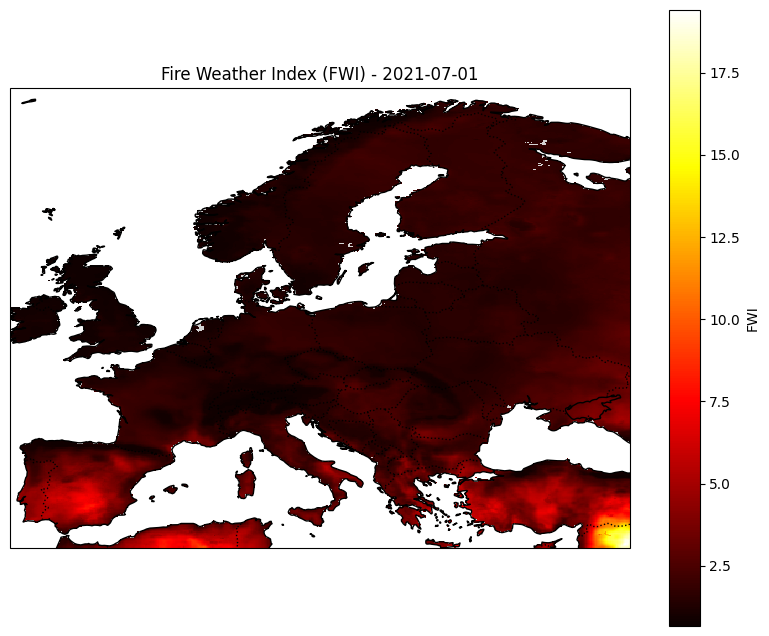

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select the 50th time slice of FWI (resulting shape: (lat, lon))
fwi_slice = ds_out['FWI'].isel(valid_time=258)

# Extract and format the date from the valid_time coordinate
date_str = ds_out['valid_time'].isel(valid_time=258).dt.strftime("%Y-%m-%d").item()

# Assume your coordinate names are 'x' for longitude and 'y' for latitude
lon = ds_out['x'].values
lat = ds_out['y'].values

# Create a 2D meshgrid of lon and lat
lon2d, lat2d = np.meshgrid(lon, lat)

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot FWI using pcolormesh.
cf = ax.pcolormesh(lon2d, lat2d, fwi_slice, cmap='hot', shading='auto')

# Add geographic features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Set the title including the date
ax.set_title(f'Fire Weather Index (FWI) - {date_str}')
cbar = plt.colorbar(cf, ax=ax, orientation='vertical', label='FWI')

plt.show()


In [ ]:
# Select the first variable (replace with a specific variable name if needed)
variable_name = list(era5.data_vars.keys())[0]  # Get the first variable
selected_variable = era5[variable_name]

# Inspect the dimensions and coordinates
print("Dimensions:", selected_variable.dims)
print("Coordinates:", selected_variable.coords)

In [ ]:
# Plot the first raster
if "time" in selected_variable.dims:  # Replace 'time' with 'valid_time' if that is your time dimension
    selected_variable.isel(time=0).plot(cmap="viridis")  # First time step
elif "valid_time" in selected_variable.dims:
    selected_variable.isel(valid_time=0).plot(cmap="viridis")  # For valid_time dimension
else:
    selected_variable.plot(cmap="viridis")  # If no time dimension exists

# Add title and labels
plt.title(f"First Raster of {variable_name}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()